<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/Machine_learning_and_process_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine learning and process simulation
Machine learning and process simulation are two powerful tools that can be used together to solve complex problems in various domains. Here's an overview of how they can be combined:

1. Data Generation: Machine learning models require a large amount of data to learn and make accurate predictions. Process simulation can be used to generate synthetic data that mimics the behavior of a real-world process. This data can then be used to train machine learning models.

2. Feature Extraction: Process simulation models often generate vast amounts of data, including various process variables and measurements. Machine learning techniques can be employed to extract relevant features from this data. These features can capture important patterns and relationships within the process, which can then be used as inputs for machine learning algorithms.

3. Model Training and Optimization: Machine learning models can be trained using the data generated by process simulations. This training can be used to develop predictive models that can estimate process variables or predict outcomes based on certain inputs. The machine learning models can be optimized using techniques like cross-validation, hyperparameter tuning, and model selection to improve their accuracy and performance.

4. Process Optimization and Control: Once trained, machine learning models can be integrated into process simulations to optimize and control the process. The models can be used to identify optimal process settings, predict failures or anomalies, and suggest corrective actions. By combining machine learning with process simulation, it becomes possible to optimize complex processes and improve efficiency.

5. Uncertainty Analysis: Process simulations often involve uncertainties due to various factors such as input variability, model assumptions, and measurement errors. Machine learning techniques, such as Bayesian inference and Monte Carlo simulation, can be used to quantify and propagate uncertainties through the model. This provides a more comprehensive understanding of the process behavior and helps make more informed decisions.

6. Model Validation: Machine learning models trained using process simulation data should be validated against real-world data to ensure their accuracy and generalizability. This involves comparing the model's predictions with actual measurements from the process. Any discrepancies can be used to refine the model or adjust simulation parameters.

#Use of NeqSim in combination with ML
In this notebook we will use NeqSim for generating synthtic data for Machine Learning algorithms. We will use https://scikit-learn.org/stable/index.html
for doing Machine Learning in Python 

In [1]:
!pip install neqsim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 35.5 MB/s eta 0:00:00


#Setting up a neqsim model for a TEG dehydration process


In [47]:
import pandas as pd

In [88]:
data = {  
          'feedGasFlowRate': [4.0, 4.5, 5.0], 
          'feedGasTemperature': [25.0, 25.0, 25.0],
          'feedGasPressure':[70.0, 70.0, 70.0],
          'absorberFeedGasTemperature':[35.0, 35.0, 35.0],
          'absorberFeedGasPressure':  [139.0, 139.0, 139.0]
        }

dataFrame = pd.DataFrame(data)
inputData = dataFrame.loc[0]



In [65]:
#Input parameters
inputData = {
  "feedGasFlowRate": 6.0, #MSm3/day
  "feedGasTemperature": 25.0, #C
  "feedGasPressure":70.0, #bara
  "absorberFeedGasTemperature": 35.0, #C
  "absorberFeedGasPressure": 139.0, #bara
  "leanTEGFlowRate": 6100.0, #kg/hr
  "leanTEGTemperature": 48.5, #C
  "flashDrumPressure": 4.8, #bara
  'reboilerPressure': 1.2, #bara
  'condenserPressure':  1.2, #bara
  'condenserTemperature': 100.0, #C
  'reboilerTemperature': 200.0, #C
  'strippingGasRate': 180.0, #kg/hr
  "strippingGasFeedTemperature": 80.0, #C
  'bufferTankTemperatureTEG': 90.5,
  'hotTEGpumpPressure': 3.0, #bara
  "regenerationGasCoolerTemperature": 50.0, #C
  'finefilterdeltaP': 0.01, #bara
  "numberOfStagesTEGabsorber": 4,
  "stageEfficiencyTEGabsorber": 0.7, #[-]
  "numberOfStagesStripper": 4,
  "stageEfficiencyStripper": 0.68, #[-]
  "UAvalueLeanRichTEGHeatExchanger": 8316.0, #W/K
  "UAvalueLeanRichTEGHeatExchanger2": 2224.0 #W/K
}

In [66]:
from neqsim.thermo import fluid, printFrame
from neqsim.process import getProcess, clearProcess, mixer, heater, stream, pump, separator, runProcess, stream, saturator, valve, filters, heatExchanger, simpleTEGAbsorber,distillationColumn, waterStripperColumn, recycle2, setpoint, calculator

def getTEGProcess():
  clearProcess()

  # Start by creating a fluid in neqsim
  feedGas = fluid("cpa")  # create a fluid using the SRK-Eo
  feedGas.addComponent("nitrogen", 0.245);
  feedGas.addComponent("CO2", 3.4);
  feedGas.addComponent("methane", 85.7);
  feedGas.addComponent("ethane", 5.981);
  feedGas.addComponent("propane", 2.743);
  feedGas.addComponent("i-butane", 0.37);
  feedGas.addComponent("n-butane", 0.77);
  feedGas.addComponent("i-pentane", 0.142);
  feedGas.addComponent("n-pentane", 0.166);
  feedGas.addComponent("n-hexane", 0.06);
  feedGas.addComponent("benzene", 0.01);
  feedGas.addComponent("water", 0.0);
  feedGas.addComponent("TEG", 0);
  feedGas.setMixingRule(10)
  feedGas.setMultiPhaseCheck(False)
  feedGas.init(0)

  dryFeedGas = stream(feedGas)
  dryFeedGas.setName('dry feed gas')
  dryFeedGas.setFlowRate(inputData['feedGasFlowRate'], 'MSm3/day')
  dryFeedGas.setTemperature(inputData['feedGasTemperature'], 'C')
  dryFeedGas.setPressure(inputData['feedGasPressure'], 'bara')

  saturatedFeedGas = saturator(dryFeedGas)
  saturatedFeedGas.setName("water saturator")

  waterSaturatedFeedGas = stream(saturatedFeedGas.getOutStream())
  waterSaturatedFeedGas.setName("water saturated feed gas")

  feedTEG = feedGas.clone()
  feedTEG.setMolarComposition([0.0,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.015, 0.985])

  feedTPsetterToAbsorber = heater(waterSaturatedFeedGas)
  feedTPsetterToAbsorber.setName('TP of gas to absorber')
  feedTPsetterToAbsorber.setOutPressure(inputData['absorberFeedGasPressure'], "bara")
  feedTPsetterToAbsorber.setOutTemperature(inputData['absorberFeedGasTemperature'], "C")

  feedToAbsorber = stream(feedTPsetterToAbsorber.getOutStream())
  feedToAbsorber.setName("feed to TEG absorber")

  TEGFeed = stream(feedTEG)
  TEGFeed.setName('lean TEG to absorber')
  TEGFeed.setFlowRate(inputData['leanTEGFlowRate'], 'kg/hr')
  TEGFeed.setTemperature(inputData['leanTEGTemperature'], 'C')
  TEGFeed.setPressure(inputData['absorberFeedGasPressure'], 'bara')

  absorber = simpleTEGAbsorber()
  absorber.setName("TEG absorber")
  absorber.addGasInStream(feedToAbsorber)
  absorber.addSolventInStream(TEGFeed)
  absorber.setNumberOfStages(inputData['numberOfStagesTEGabsorber'])
  absorber.setStageEfficiency(inputData['stageEfficiencyTEGabsorber'])

  dehydratedGas = stream(absorber.getGasOutStream())
  dehydratedGas.setName('dry gas from absorber')

  richTEG = stream(absorber.getSolventOutStream())
  richTEG.setName("rich TEG from absorber")

  glycol_flash_valve = valve(richTEG)
  glycol_flash_valve.setName("Rich TEG HP flash valve")
  glycol_flash_valve.setOutletPressure(inputData['flashDrumPressure'])

  richGLycolHeaterCondenser = heater(glycol_flash_valve.getOutStream())
  richGLycolHeaterCondenser.setName("rich TEG preheater")

  heatEx2 = heatExchanger(richGLycolHeaterCondenser.getOutStream())
  heatEx2.setName("cold lean/rich TEG heat-exchanger")
  heatEx2.setGuessOutTemperature(273.15 + 60.0)
  heatEx2.setUAvalue(inputData['UAvalueLeanRichTEGHeatExchanger2'])

  flashSep = separator(heatEx2.getOutStream(0))
  flashSep.setName("degasing separator")

  flashGas = stream(flashSep.getGasOutStream())
  flashGas.setName("gas from degasing separator")

  flashLiquid = stream(flashSep.getLiquidOutStream())
  flashLiquid.setName("liquid from degasing separator")

  fineFilter = filters(flashLiquid)
  fineFilter.setName("TEG fine filter")
  fineFilter.setDeltaP(inputData['finefilterdeltaP'], "bara")

  heatEx = heatExchanger(fineFilter.getOutStream())
  heatEx.setName("lean/rich TEG heat-exchanger")
  heatEx.setGuessOutTemperature(273.15 + 130.0)
  heatEx.setUAvalue(inputData['UAvalueLeanRichTEGHeatExchanger'])

  glycol_flash_valve2 = valve(heatEx.getOutStream(0))
  glycol_flash_valve2.setName("Rich TEG LP flash valve")
  glycol_flash_valve2.setOutletPressure(inputData['reboilerPressure'])

  stripGas = feedGas.clone()

  strippingGas = stream(stripGas)
  strippingGas.setName('stripGas')
  strippingGas.setFlowRate(inputData['strippingGasRate'], "Sm3/hr")
  strippingGas.setTemperature(inputData['strippingGasFeedTemperature'], "C")
  strippingGas.setPressure(inputData['reboilerPressure'], "bara")

  gasToReboiler = strippingGas.clone()
  gasToReboiler.setName("gas to reboiler")

  column = distillationColumn(1, True, True)
  column.setName("TEG regeneration column")
  column.addFeedStream(glycol_flash_valve2.getOutStream(), 1)
  column.getReboiler().setOutTemperature(273.15 + inputData['reboilerTemperature'])
  column.getCondenser().setOutTemperature(273.15 + inputData['condenserTemperature'])
  column.getTray(1).addStream(gasToReboiler)
  column.setTopPressure(inputData['condenserPressure'])
  column.setBottomPressure(inputData['reboilerPressure'])

  coolerRegenGas = heater(column.getGasOutStream())
  coolerRegenGas.setName("regen gas cooler")
  coolerRegenGas.setOutTemperature(273.15 + inputData['regenerationGasCoolerTemperature'])

  sepregenGas = separator(coolerRegenGas.getOutStream())
  sepregenGas.setName("regen gas separator");

  gasToFlare = stream(sepregenGas.getGasOutStream())
  gasToFlare.setName("gas to flare");

  liquidToTrreatment = stream(sepregenGas.getLiquidOutStream())
  liquidToTrreatment.setName("water to treatment")

  stripper = waterStripperColumn("TEG stripper")
  stripper.addSolventInStream(column.getLiquidOutStream())
  stripper.addGasInStream(strippingGas)
  stripper.setNumberOfStages(inputData['numberOfStagesStripper'])
  stripper.setStageEfficiency(inputData['stageEfficiencyStripper'])

  recycleGasFromStripper = recycle2("stripping gas recirc")
  recycleGasFromStripper.addStream(stripper.getGasOutStream())
  recycleGasFromStripper.setOutletStream(gasToReboiler)

  heatEx.setFeedStream(1, stripper.getSolventOutStream())

  bufferTank = heater(heatEx.getOutStream(1))
  bufferTank.setName("TEG buffer tank")
  bufferTank.setOutTemperature(273.15 + inputData['bufferTankTemperatureTEG'])

  hotLeanTEGPump = pump(bufferTank.getOutStream(),inputData['hotTEGpumpPressure'],"lean TEG LP pump")

  heatEx2.setFeedStream(1, hotLeanTEGPump.getOutStream())

  coolerhOTteg3 = heater(heatEx2.getOutStream(1))
  coolerhOTteg3.setName("lean TEG cooler")
  coolerhOTteg3.setOutTemperature(273.15 + inputData['leanTEGTemperature'])

  hotLeanTEGPump2 = pump(coolerhOTteg3.getOutStream(), inputData['absorberFeedGasPressure'], "lean TEG HP pump")
  hotLeanTEGPump2.setName("lean TEG HP pump")
  hotLeanTEGPump2.setOutletPressure(inputData['absorberFeedGasPressure'])

  pumpHPPresSet = setpoint("HP pump set", hotLeanTEGPump2, "pressure", feedToAbsorber)

  leanTEGtoabs = stream(hotLeanTEGPump2.getOutStream())
  leanTEGtoabs.setName("lean TEG to absorber")

  pureTEG = feedGas.clone()
  pureTEG.setMolarComposition([0.0,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

  makeupTEG = stream(pureTEG)
  makeupTEG.setName("makeup TEG")
  makeupTEG.setFlowRate(1e-6, "kg/hr")
  makeupTEG.setTemperature(inputData['leanTEGTemperature'], "C")
  makeupTEG.setPressure(inputData['absorberFeedGasPressure'], "bara")

  makeupCalculator = calculator("TEG makeup calculator")
  makeupCalculator.addInputVariable(dehydratedGas)
  makeupCalculator.addInputVariable(flashGas)
  makeupCalculator.addInputVariable(gasToFlare)
  makeupCalculator.addInputVariable(liquidToTrreatment)
  makeupCalculator.setOutputVariable(makeupTEG)

  makeupMixer = mixer("makeup mixer")
  makeupMixer.addStream(leanTEGtoabs)
  makeupMixer.addStream(makeupTEG)

  resycleLeanTEG = recycle2("lean TEG resycle")
  resycleLeanTEG.addStream(makeupMixer.getOutStream())
  resycleLeanTEG.setOutletStream(TEGFeed)
  resycleLeanTEG.setPriority(200)
  resycleLeanTEG.setDownstreamProperty("flow rate")

  richGLycolHeaterCondenser.setEnergyStream(column.getCondenser().getEnergyStream())

  TEGprocess = getProcess()
  return TEGprocess.copy()

# Start simulation

In [67]:
processes = []
for i in range(1):
  #inputData = dataFrame.loc[i]
  process = getTEGProcess()
  process.runAsThread()
  processes.append(process)



In [104]:
inpdataframe = dataFrame.copy()
import random
drygaswaterppm = []
reboilerdutykW = []
for i in range(3):
  drygaswaterppm.append(processes[0].getUnit("dry gas from absorber").getFluid().getPhase(0).getComponent('water').getz()*1.0e6+random.random())
  reboilerdutykW.append(processes[0].getUnit("TEG regeneration column").getReboiler().getDuty()/1.0e3+random.random())

dict = {
        'drygasppm': drygaswaterppm,
        'reboilerdutykW': reboilerdutykW
        } 

resultsDF = pd.DataFrame(dict)

print(resultsDF)
inpdataframe

   drygasppm  reboilerdutykW
0   4.586189      268.496767
1   4.697017      268.241304
2   5.304551      268.389650


,feedGasFlowRate,feedGasTemperature,feedGasPressure,absorberFeedGasTemperature,absorberFeedGasPressure
0,4.0,25.0,70.0,35.0,139.0
1,4.5,25.0,70.0,35.0,139.0
2,5.0,25.0,70.0,35.0,139.0


# Read results from simulation

In [28]:
wetGasRatekghr = TEGprocess.getUnit("water saturated feed gas").getFlowRate("kg/hr")
waterInWetGasppm = TEGprocess.getUnit("water saturated feed gas").getFluid().getPhase(0).getComponent('water').getz()*1.0e6
waterInDryGasppm = TEGprocess.getUnit("dry gas from absorber").getFluid().getPhase(0).getComponent('water').getz()*1.0e6
waterInWetGaskgMSm3 = waterInWetGasppm*0.01802*101325.0/(8.314*288.15)
waterInDryGaskgMSm3 = waterInDryGasppm*0.01802*101325.0/(8.314*288.15)
waterInWetGaskghr = waterInWetGaskgMSm3*TEGprocess.getUnit("water saturated feed gas").getFlowRate("Sm3/day")/1.0e6/24.0
waterInDryGaskghr = waterInDryGaskgMSm3*TEGprocess.getUnit("dry gas from absorber").getFlowRate("Sm3/day")/1.0e6/24.0
waterInDryGaskgMSm3 = waterInDryGasppm*0.01802*101325.0/(8.314*288.15)
wtLeanTEGFromReboiler = TEGprocess.getUnit("TEG regeneration column").getLiquidOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
wtLeanTEGFromStripper = TEGprocess.getUnit("TEG stripper").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
wtWaterFromStripper = TEGprocess.getUnit("TEG stripper").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("water")*100.0
wtRichTEGFromAbsorber = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
richTEGtemperature = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getTemperature("C")
waterInRichTEGkghr = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("water")*TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getFlowRate("kg/hr")
TEGcirculationratelitreperkg = TEGprocess.getUnit("TEG absorber").getSolventInStream().getFlowRate("kg/hr")*wtLeanTEGFromStripper/100/waterInWetGaskghr
richTEGtemperatureAfterDepres = TEGprocess.getUnit("Rich TEG HP flash valve").getOutStream().getFluid().getTemperature("C")
RichTEGwtprbinary = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")/(TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")+TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("water"))*100
reboilerdutykW = TEGprocess.getUnit("TEG regeneration column").getReboiler().getDuty()/1.0e3
condenserdutykW = TEGprocess.getUnit("TEG regeneration column").getCondenser().getDuty()/1.0e3
condensertemperature= TEGprocess.getUnit("TEG regeneration column").getCondenser().getTemperature()-273.15
reboilertemperature= TEGprocess.getUnit("TEG regeneration column").getReboiler().getTemperature()-273.15
TEGmakeupkghr = TEGprocess.getUnit("TEG makeup calculator").getOutputVariable().getFluid().getFlowRate("kg/hr")
TEGmakeupkgMSm3 = TEGmakeupkghr/TEGprocess.getUnit("dry feed gas").getFlowRate("Sm3/day")/1.0e6*24
leanTEGflow = TEGprocess.getUnit("TEG absorber").getSolventInStream().getFlowRate("kg/hr")
richTEGflow = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFlowRate("kg/hr")
pump2DutykW = TEGprocess.getUnit("lean TEG HP pump").getEnergy()/1.0e3
flashGasRate = TEGprocess.getUnit("gas from degasing separator").getFlowRate("kg/hr")
gasToFLareRatekghr = TEGprocess.getUnit("gas to flare").getFlowRate("kg/hr")
stripGasRatekghr = TEGprocess.getUnit("stripGas").getFlowRate("kg/hr")
waterToTreatment = TEGprocess.getUnit("water to treatment").getFlowRate("kg/hr")
TEGinwatertoTreatmentwtprecent = TEGprocess.getUnit("water to treatment").getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
flowFromReboiler = TEGprocess.getUnit("TEG regeneration column").getReboiler().getLiquidOutStream().getFlowRate("kg/hr")
richTEGpreheaterDutykW = TEGprocess.getUnit("rich TEG preheater").getDuty()/1000.0
richTEGpreheaterTemperature = TEGprocess.getUnit("rich TEG preheater").getOutStream().getTemperature("C")
richTEGtemperatureOutOfLPflashValve = TEGprocess.getUnit("Rich TEG LP flash valve").getOutStream().getTemperature("C")
#waterInGasFromCondenser= TEGprocess.getUnit("TEG regeneration column").getCondenser().getGasOutStream().getFlowRate("kg/hr")*TEGprocess.getUnit("TEG regeneration column").getCondenser().getGasOutStream().getFluid().getPhase(0).getWtFrac("water")
richTEGtemperatureIntoHX1 = TEGprocess.getUnit("lean/rich TEG heat-exchanger").getOutStream(0).getTemperature("C")
richTEGtemperatureOutHX1 = TEGprocess.getUnit("lean/rich TEG heat-exchanger").getOutStream(0).getTemperature("C")
leanTEGtemperatureintoHX1  = TEGprocess.getUnit("lean/rich TEG heat-exchanger").getOutStream(1).getTemperature("C")   
leanTEGtemperatureoutTEGHX1 =  TEGprocess.getUnit("lean/rich TEG heat-exchanger").getOutStream(1).getTemperature("C")

ZeroDivisionError: ignored

#Setting up the Machine Learning model

In [109]:
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

X = dataFrame.to_numpy()
y = resultsDF

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_1.fit(X, y)

y_1 = regr_1.predict(X)
print(resultsDF)
y_1


   drygasppm  reboilerdutykW
0   4.586189      268.496767
1   4.697017      268.241304
2   5.304551      268.389650


array([[  4.58618886, 268.49676714],
       [  4.69701665, 268.24130445],
       [  5.30455111, 268.38964971]])

In [ ]:

X = inputData.to_numpy()
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng
)

regr_1.fit(X, y)
regr_2.fit(X, y)

y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

plotting rusults

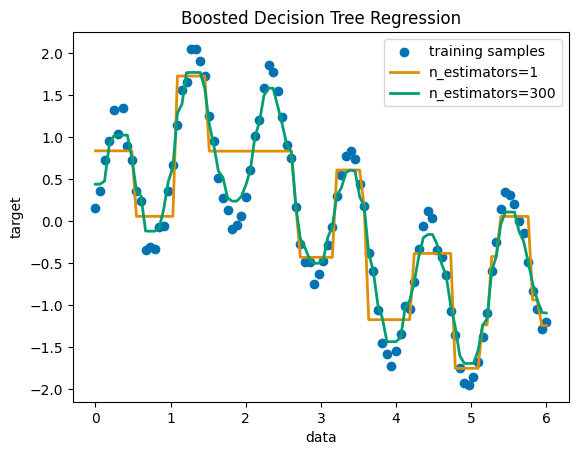

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("colorblind")

plt.figure()
plt.scatter(X, y, color=colors[0], label="training samples")
plt.plot(X, y_1, color=colors[1], label="n_estimators=1", linewidth=2)
plt.plot(X, y_2, color=colors[2], label="n_estimators=300", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()